# MYCONET PROJECT - Part 1 EDA



Step 0. Mount google drive

---



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 1. Download the Fungi dataset from Kaggle

---



In [ ]:
# Copy kaggle.json to ~/.kaggle and set permissions
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset using Kaggle CLI
!kaggle datasets download -d joebeachcapital/defungi

# Unzip to a folder in Google Drive
!unzip -q defungi.zip -d /content/drive/MyDrive/SDS/myconet/defungi_dataset

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/defungi
License(s): Attribution 4.0 International (CC BY 4.0)
 78% 116M/149M [00:00<00:00, 1.22GB/s]
100% 149M/149M [00:00<00:00, 1.05GB/s]


Step 1.1 Check folder structure and count of files under them

---



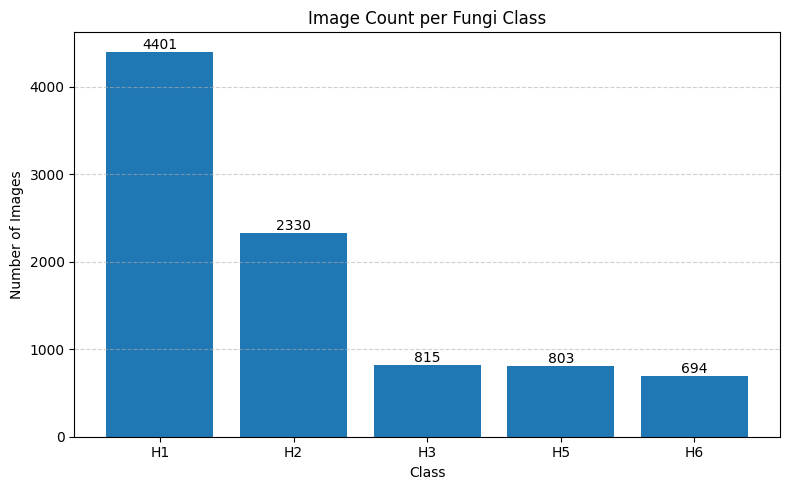

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the dataset path
dataset_path = '/content/drive/MyDrive/SDS/myconet/defungi_dataset'

# Dictionary to store counts
folder_counts = {}

# Count files in each class folder
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        file_count = len([
            f for f in os.listdir(folder_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
        ])
        folder_counts[folder_name] = file_count

# Sort by class name
sorted_counts = dict(sorted(folder_counts.items()))
classes = list(sorted_counts.keys())
counts = list(sorted_counts.values())

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(classes, counts)
plt.title("Image Count per Fungi Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,  # small offset above the bar
        f'{height}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


Step 1.2 Verify that the files are valid images, not duplicates and not corrupt

---



In [ ]:
import os
import hashlib
from PIL import Image

# Path to dataset
dataset_path = '/content/drive/MyDrive/SDS/myconet/defungi_dataset'

# Trackers
non_image_files = []
corrupt_images = []
hash_dict = {}
duplicate_files = []

# Supported image extensions
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

# Helper function to compute MD5 hash of a file
def get_file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

# Iterate over each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            # 1. Check for valid extension
            if not file_name.lower().endswith(image_extensions):
                non_image_files.append(file_path)
                continue

            # 2. Check for corruption
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except:
                corrupt_images.append(file_path)
                continue

            # 3. Check for duplicates
            file_hash = get_file_hash(file_path)
            if file_hash in hash_dict:
                duplicate_files.append((file_path, hash_dict[file_hash]))  # current, original
            else:
                hash_dict[file_hash] = file_path

# Report Results
if non_image_files:
    print(f"\n⚠️ Found {len(non_image_files)} non-image files:")
    for f in non_image_files:
        print(f)

if corrupt_images:
    print(f"\n❌ Found {len(corrupt_images)} corrupt image files:")
    for f in corrupt_images:
        print(f)

if duplicate_files:
    print(f"\n🔁 Found {len(duplicate_files)} duplicate images:")
    for dup, orig in duplicate_files:
        print(f"Duplicate: {dup}  --> Original: {orig}")

if not (non_image_files or corrupt_images or duplicate_files):
    print("✅ All files are valid, unique image files.")


✅ All files are valid, unique image files.


Remove duplicates. This will retain the 'Original' occurance and move the 'Duplicate' to an alternate folder grouped by class

---



In [ ]:
import os
import shutil
import hashlib

# Paths
dataset_path = '/content/drive/MyDrive/SDS/myconet/defungi_dataset'
duplicates_base = '/content/drive/MyDrive/SDS/myconet/defungi_duplicates'

# Create base duplicates folder
os.makedirs(duplicates_base, exist_ok=True)

# Hash tracker and move log
hash_dict = {}
moved_files = []

# Function to compute MD5 hash of file
def get_file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

# Walk through each class folder and check for duplicates
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            try:
                file_hash = get_file_hash(file_path)

                if file_hash in hash_dict:
                    # Make class-specific subfolder in duplicates directory
                    class_dup_path = os.path.join(duplicates_base, class_name)
                    os.makedirs(class_dup_path, exist_ok=True)

                    # Destination path with same filename
                    new_path = os.path.join(class_dup_path, file_name)

                    # If filename already exists in destination, rename to avoid overwrite
                    counter = 1
                    while os.path.exists(new_path):
                        name, ext = os.path.splitext(file_name)
                        new_path = os.path.join(class_dup_path, f"{name}_{counter}{ext}")
                        counter += 1

                    shutil.move(file_path, new_path)
                    moved_files.append(new_path)

                else:
                    hash_dict[file_hash] = file_path

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Report
print(f"\n✅ Moved {len(moved_files)} duplicate files.")
if moved_files:
    print("Sample of moved files:")
    for f in moved_files[:5]:
        print(f"→ {f}")




✅ Moved 59 duplicate files.
Sample of moved files:
→ /content/drive/MyDrive/SDS/myconet/defungi_duplicates/H2/H2_95d_3.jpg
→ /content/drive/MyDrive/SDS/myconet/defungi_duplicates/H2/H2_95d_4.jpg
→ /content/drive/MyDrive/SDS/myconet/defungi_duplicates/H3/H3_3d_5.jpg
→ /content/drive/MyDrive/SDS/myconet/defungi_duplicates/H3/H3_3d_6.jpg
→ /content/drive/MyDrive/SDS/myconet/defungi_duplicates/H5/H5_114a_1.jpg


# PART -2

Create a Set of Class Names with Label mapping

In [ ]:
import os
import json

# Dataset path
dataset_path = '/content/drive/MyDrive/SDS/myconet/defungi_dataset'

# Get sorted class names
class_names = sorted([
    name for name in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, name))
])

# Create mappings
class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}
label_to_class = {idx: class_name for class_name, idx in class_to_label.items()}

# Save to JSON
output_path = '/content/drive/MyDrive/SDS/myconet/class_label_mapping.json'

with open(output_path, 'w') as f:
    json.dump({
        "class_to_label": class_to_label,
        "label_to_class": label_to_class
    }, f, indent=4)

print(f"✅ Class-label mappings saved to: {output_path}")



✅ Class-label mappings saved to: /content/drive/MyDrive/SDS/myconet/class_label_mapping.json


Dataset Curation and Labeling

H-folders found: {'H1': 0, 'H2': 1, 'H3': 2, 'H5': 3, 'H6': 4}
Classes found: [0 4 3 2 1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9043 entries, 0 to 9042
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      9043 non-null   object
 1   label     9043 non-null   object
 2   class_id  9043 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 212.1+ KB


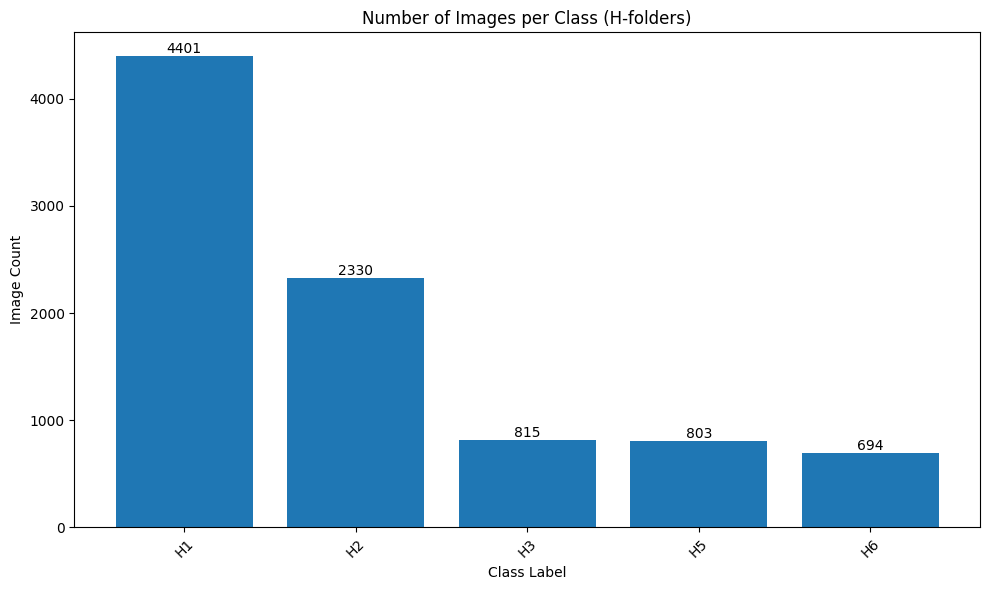

In [ ]:
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import json

# Step 1: Define root path
root_path = '/content/drive/MyDrive/SDS/myconet/defungi_dataset/'


# Step 2: Get all H-folders
h_folders = [f for f in os.listdir(root_path) if f.startswith('H') and os.path.isdir(os.path.join(root_path, f))]
h_folders.sort()

# Step 3: Create label-to-class_id dictionary
label_dict = {label: i for i, label in enumerate(h_folders)}
print(f"H-folders found: {label_dict}")

# Step 4: Collect image data
all_data = []

for label in h_folders:
    jpg_files = glob(os.path.join(root_path, label, '*.jpg'))
    class_id = label_dict[label]

    for jpg_path in jpg_files:
        all_data.append({
            "path": jpg_path,
            "label": label,
            "class_id": class_id
        })

# Step 5: Convert to DataFrame and shuffle
df = pd.DataFrame(all_data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 6: Save DataFrame and label dictionary
df.to_csv('/content/drive/MyDrive/SDS/myconet/defungi_dataset/fungi_dataset.csv', index=False)
df.to_json('/content/drive/MyDrive/SDS/myconet/defungi_dataset/fungi_dataset.json', orient='records', indent=2)

with open('/content/drive/MyDrive/SDS/myconet/defungi_dataset/class_mapping.json', 'w') as f:
    json.dump(label_dict, f, indent=2)

# Step 7: Display dataset summary
print(f"Classes found: {df['class_id'].unique()}")
df.info()


# Step 8: Visualization – Bar chart of image counts
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values)

# Add count labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height),
             ha='center', va='bottom', fontsize=10)

plt.title('Number of Images per Class (H-folders)')
plt.xlabel('Class Label')
plt.ylabel('Image Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df.tail()

,path,label,class_id
9038,/content/drive/MyDrive/SDS/myconet/defungi_dat...,H2,1
9039,/content/drive/MyDrive/SDS/myconet/defungi_dat...,H2,1
9040,/content/drive/MyDrive/SDS/myconet/defungi_dat...,H2,1
9041,/content/drive/MyDrive/SDS/myconet/defungi_dat...,H1,0
9042,/content/drive/MyDrive/SDS/myconet/defungi_dat...,H3,2


In [ ]:
df.head()

,path,label,class_id
0,/content/drive/MyDrive/SDS/myconet/defungi_dat...,H1,0
1,/content/drive/MyDrive/SDS/myconet/defungi_dat...,H1,0
2,/content/drive/MyDrive/SDS/myconet/defungi_dat...,H1,0
3,/content/drive/MyDrive/SDS/myconet/defungi_dat...,H1,0
4,/content/drive/MyDrive/SDS/myconet/defungi_dat...,H6,4


Import Libraries

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 18.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, sqrt

import time

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



Imported pandas, numpy mlflow etc


ML Flow

---



In [ ]:
import mlflow
from mlflow.tracking import MlflowClient

# 1) Set the overall tracking URI to your Drive folder:
tracking_uri = "file:///content/drive/MyDrive/SDS/myconet/mlruns"
mlflow.set_tracking_uri(tracking_uri)

# 2) Create (or fetch) your experiment, specifying the artifact_location:
client = MlflowClient()
experiment_name = "MycoNet_EfficientNet"

# If it doesn't exist yet, this will create it *with* your folder as the root:
experiment = client.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = client.create_experiment(
        name=experiment_name,
        artifact_location=tracking_uri
    )
else:
    experiment_id = experiment.experiment_id

# 3) Now tell MLflow to use that experiment for all subsequent runs:
mlflow.set_experiment(experiment_name=experiment_name)



<Experiment: artifact_location='file:///content/drive/MyDrive/SDS/myconet/mlruns', creation_time=1751681485426, experiment_id='399522367250474202', last_update_time=1751681485426, lifecycle_stage='active', name='MycoNet_EfficientNetV2', tags={}>

In [ ]:
import mlflow.pytorch
mlflow.pytorch.autolog()

In [ ]:

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
import torchsummary

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

print("Imported torch etc")

Imported torch etc


Define Utility Functions:

In [ ]:
"""
    Returns a dictionary with the count of samples per class.
"""
def get_class_distribution(df, label_col='class_id'):

    return df[label_col].value_counts().sort_index().to_dict()

"""
    Computes class weights inversely proportional to their frequencies.
    Returns a dictionary: {class_id: weight}
"""
def calculate_balanced_class_weights(class_counts):

    total = sum(class_counts.values())
    num_classes = len(class_counts)

    # Compute weight for each class
    weights = {cls: total / (num_classes * count) for cls, count in class_counts.items()}
    return weights

"""
    Converts class weights dictionary to a PyTorch tensor on the specified device.
"""
import torch

def weights_to_tensor(weights, device='cuda' if torch.cuda.is_available() else 'cpu'):

    # Ensure correct order by sorting keys
    weight_list = [weights[k] for k in sorted(weights.keys())]
    return torch.tensor(weight_list, dtype=torch.float32).to(device)

"""
    Nicely formats and prints class distribution and corresponding weights.
"""
def print_class_info(class_counts, weights):

    print("Class ID | Samples | Weight")
    print("-----------------------------")
    for cls in sorted(class_counts):
        print(f"{cls:^8} | {class_counts[cls]:^7} | {weights[cls]:.4f}")



In [ ]:
# Prepare class weights for imbalanced dataset
class_counts = get_class_distribution(df)
weights = calculate_balanced_class_weights(class_counts)
class_weights_tensor = weights_to_tensor(weights)

# Display
print_class_info(class_counts, weights)
print(f"Device: {class_weights_tensor.device}")

# Use in training
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


Class ID | Samples | Weight
-----------------------------
   0     |  4401   | 0.4110
   1     |  2330   | 0.7762
   2     |   815   | 2.2191
   3     |   803   | 2.2523
   4     |   694   | 2.6061
Device: cuda:0


Show sample image per class

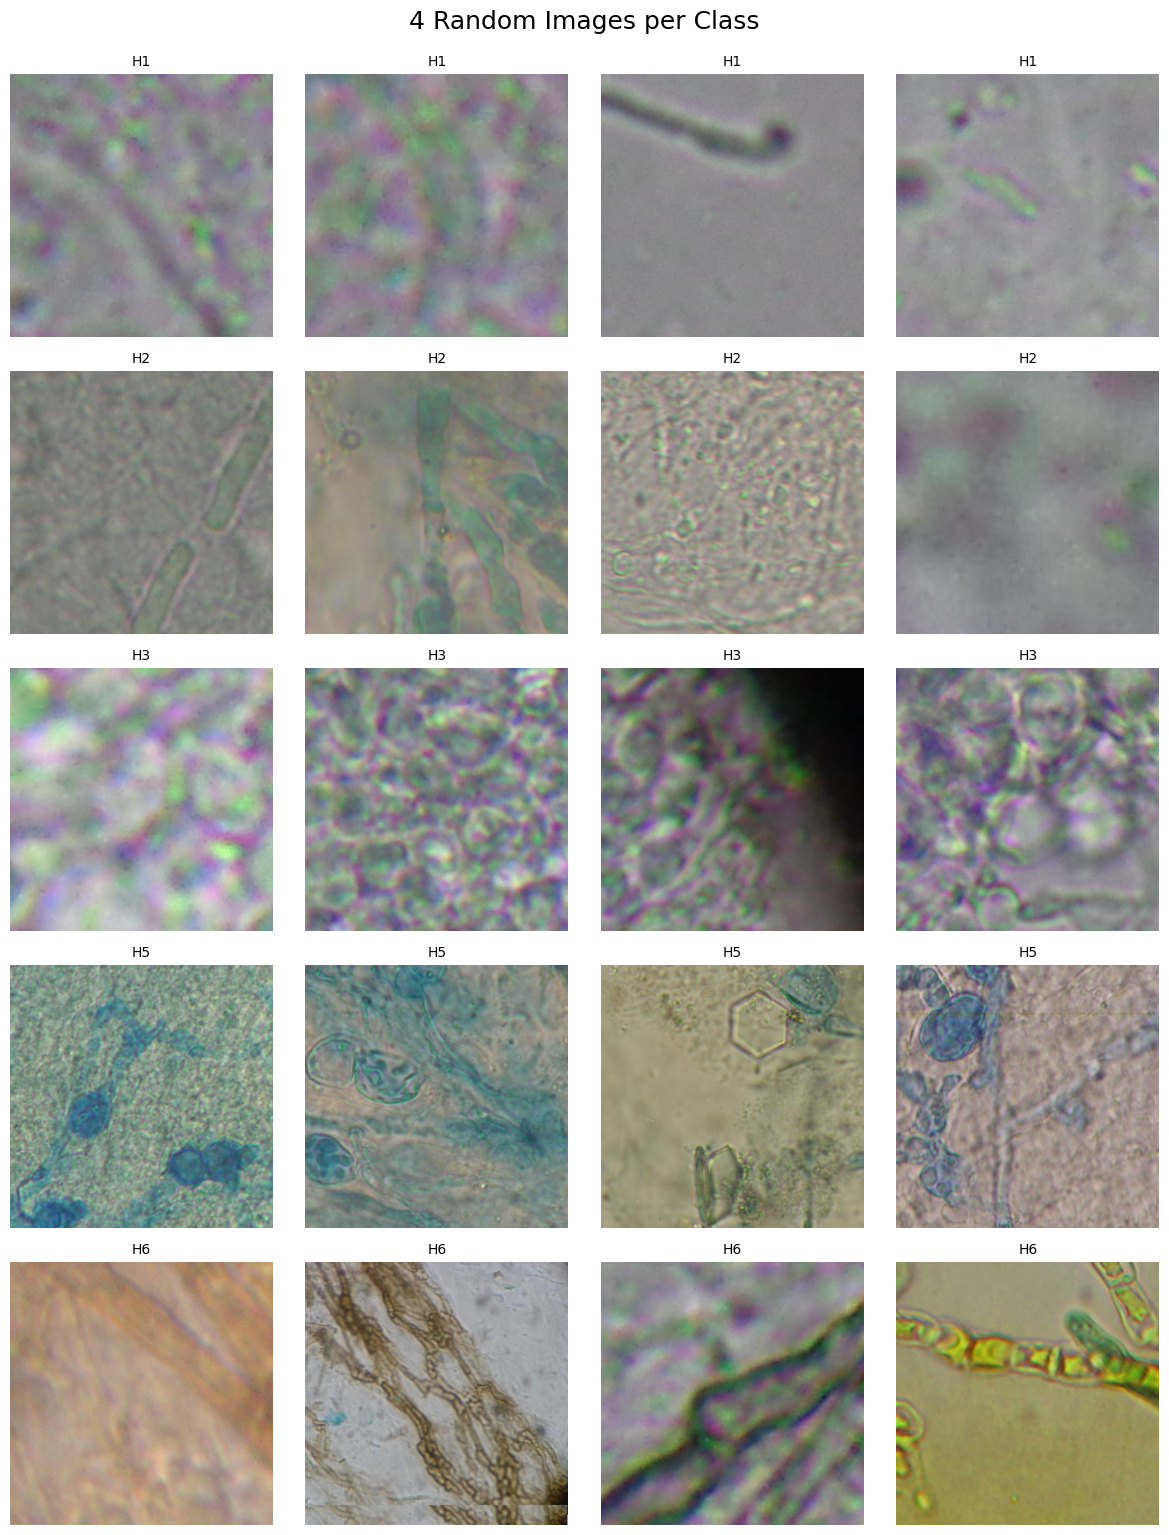

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import random

# Dataset path
dataset_path = '/content/drive/MyDrive/SDS/myconet/defungi_dataset/'

# Get H-folders (classes)
class_folders = sorted([f for f in os.listdir(dataset_path) if f.startswith('H') and os.path.isdir(os.path.join(dataset_path, f))])

# Plot settings
num_images_per_class = 4
plt.figure(figsize=(num_images_per_class * 3, len(class_folders) * 3))

# Loop through each class
for row_idx, class_name in enumerate(class_folders):
    class_path = os.path.join(dataset_path, class_name)
    image_paths = glob(os.path.join(class_path, '*.jpg'))

    # Select 4 random images or as many as available
    selected_images = random.sample(image_paths, min(num_images_per_class, len(image_paths)))

    for col_idx, image_path in enumerate(selected_images):
        img = Image.open(image_path)

        # Plotting in a grid (rows = classes, columns = samples)
        plt_idx = row_idx * num_images_per_class + col_idx + 1
        plt.subplot(len(class_folders), num_images_per_class, plt_idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name, fontsize=10)  # Show class name on each image

plt.tight_layout()
plt.suptitle("4 Random Images per Class", fontsize=18, y=1.02)
plt.show()


Data Augmentation and Image Preprocessing

In [ ]:
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

# Core preprocessing (same for all splits)
base_preprocessing = [
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]

# Augmentation operations (only for train dataset)
augmentation_ops = [
    v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1, 0.15))
]

# Eval/test preprocessing (deterministic resize)
eval_preprocessing = [v2.Resize((224, 224))]

# Compose transforms
train_transforms = v2.Compose(augmentation_ops + base_preprocessing)
eval_transforms = v2.Compose(eval_preprocessing + base_preprocessing)
test_transforms = eval_transforms


Code to Visualize Transform Effects

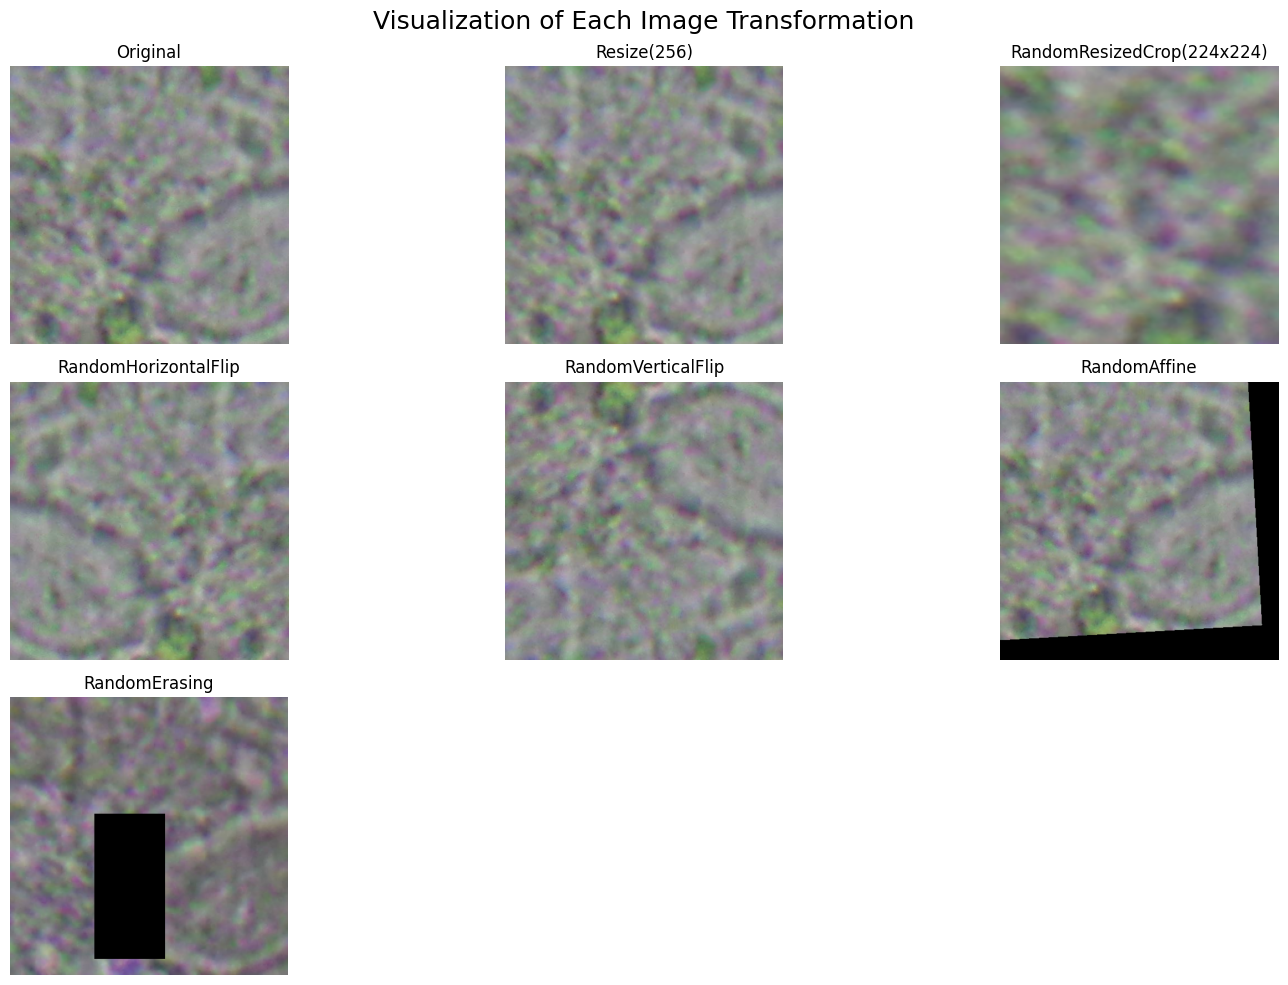

In [ ]:
import torch
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
from PIL import Image
import os
# Load a sample image (you can replace this with any image path from your dataset)
sample_image_path = '/content/drive/MyDrive/SDS/myconet/defungi_dataset/H1/H1_100a_1.jpg'
image = Image.open(sample_image_path).convert("RGB")

# Define each transform individually
transforms_to_visualize = {
    "Original": lambda x: x,
    "Resize(256)": v2.Compose([v2.Resize(256)]),
    "RandomResizedCrop(224x224)": v2.Compose([v2.Resize(256), v2.RandomResizedCrop(224)]),
    "RandomHorizontalFlip": v2.Compose([v2.RandomHorizontalFlip(p=1.0)]),
    "RandomVerticalFlip": v2.Compose([v2.RandomVerticalFlip(p=1.0)]),
    "RandomAffine": v2.Compose([v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1))]),
    "RandomErasing": v2.Compose([
        v2.Resize((224, 224)),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32),
        v2.RandomErasing(p=1.0, scale=(0.1, 0.15)),
        v2.ToPILImage()
    ])
}

# Apply and visualize each transform
plt.figure(figsize=(15, 10))
for i, (name, transform) in enumerate(transforms_to_visualize.items(), 1):
    transformed_img = transform(image)
    plt.subplot(3, 3, i)
    plt.imshow(transformed_img)
    plt.title(name)
    plt.axis('off')

plt.suptitle("Visualization of Each Image Transformation", fontsize=18)
plt.tight_layout()
plt.show()


Generate a PyTorch-friendly dataset from pandas DataFrame (with image paths and labels) that can be loaded in batches using a DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image, UnidentifiedImageError
import os

class FungalDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_transform=None, return_filename=False):
        self.df = dataframe
        self.transform = transform
        self.target_transform = target_transform
        self.return_filename = return_filename

    # Needed so PyTorch knows the dataset size.
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['path']
        try:
            image = Image.open(image_path).convert("RGB")
        except (FileNotFoundError, UnidentifiedImageError):
            print(f"[Warning] Problem loading: {image_path}")
            return self.__getitem__((idx + 1) % len(self.df))  # Retry next item

        if self.transform:
            image = self.transform(image)

        class_id = self.df.iloc[idx]['class_id']
        if self.target_transform:
            class_id = self.target_transform(class_id)

        if self.return_filename:
            return image, class_id, os.path.basename(image_path)

        return image, class_id


Split dataset into Train, Validation and Test

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
from PIL import Image

# --- Utility Functions ---

def print_split_info(name, df):
    print(f"{name} Split: {len(df)} samples")
    print(df['label'].value_counts(normalize=True).sort_index())  # Show % per class
    print('-' * 40)

def check_overlap(df1, df2, name1='Set1', name2='Set2'):
    overlap = set(df1['path']) & set(df2['path'])
    if overlap:
        print(f"⚠️ Overlap detected between {name1} and {name2}: {len(overlap)} overlapping files")
    else:
        print(f"✅ No overlap between {name1} and {name2}")

# --- Split Parameters ---
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

# --- Split Step 1: 80% train, 20% val+test ---
train_df, val_test_df = train_test_split(
    df,
    test_size=(val_ratio + test_ratio),
    stratify=df['label'],  # or df['class_id'] if preferred
    random_state=9898
)

# --- Split Step 2: 10% val, 10% test ---
val_df, test_df = train_test_split(
    val_test_df,
    test_size=test_ratio / (val_ratio + test_ratio),  # = 0.5 of the 20%
    stratify=val_test_df['label'],
    random_state=9898
)

# --- Sanity Checks ---
print_split_info("Train", train_df)
print_split_info("Validation", val_df)
print_split_info("Test", test_df)

check_overlap(train_df, val_df, "Train", "Validation")
check_overlap(train_df, test_df, "Train", "Test")
check_overlap(val_df, test_df, "Validation", "Test")


# --- Create Dataset Objects ---
train_dataset = FungalDataset(train_df, transform=train_transforms)
val_dataset   = FungalDataset(val_df, transform=eval_transforms)
test_dataset  = FungalDataset(test_df, transform=test_transforms)


Train Split: 7234 samples
label
H1    0.486729
H2    0.257672
H3    0.090130
H5    0.088748
H6    0.076721
Name: proportion, dtype: float64
----------------------------------------
Validation Split: 904 samples
label
H1    0.486726
H2    0.257743
H3    0.089602
H5    0.088496
H6    0.077434
Name: proportion, dtype: float64
----------------------------------------
Test Split: 905 samples
label
H1    0.486188
H2    0.257459
H3    0.090608
H5    0.089503
H6    0.076243
Name: proportion, dtype: float64
----------------------------------------
✅ No overlap between Train and Validation
✅ No overlap between Train and Test
✅ No overlap between Validation and Test


Create Dataloader to handle batching and  shuffling

In [ ]:
from torch.utils.data import DataLoader

# Define batch size
BATCH_SIZE = 32  # You can increase based on your GPU memory
NUM_WORKERS = 2  # Adjust based on system. 0 = no multiprocessing.

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,             # Shuffle for training only
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,            # Don't shuffle validation
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,            # Don't shuffle test
    num_workers=NUM_WORKERS,
    pin_memory=True
)


Weight Initializations
*   Convolutional layers → He (Kaiming) Initialization
*   Linear (Fully Connected) layers → Xavier Initialization
*   BatchNorm layers → Standard initialization

In [ ]:
import torch.nn as nn

def init_weights(module):
    """Applies He initialization to Conv layers, Xavier to Linear, and standard to BatchNorm."""

    if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

    elif isinstance(module, nn.Linear):
        nn.init.xavier_normal_(module.weight)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)

def apply_weight_init(model):
    """Applies init_weights to all layers of a model."""
    model.apply(init_weights)


Create Simple 2 layer CNN

---



In [ ]:
class BasicCNN(nn.Module):
  def __init__(self, num_classes=5, dropout_rate=0.5):
        super(BasicCNN, self).__init__()

        # Convolutional Block 1: Input -> 16 channels
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 224 → 112
        )

        # Convolutional Block 2: 16 -> 32 channels
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 112 → 56
        )

        # Fully Connected Layer
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(32 * 56 * 56, num_classes)  # Output from conv blocks = 32×56×56

        # Optional: Custom weight initialization
        self.apply(init_weights)


  def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
model = BasicCNN(num_classes=5)
print(model)

BasicCNN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=100352, out_features=5, bias=True)
)


Deeper 4 layer model

---



In [ ]:
import torch
import torch.nn as nn

class DeepCNN(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super(DeepCNN, self).__init__()

        # Convolutional block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Convolutional block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Convolutional block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Convolutional block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Common layers
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(256 * 14 * 14, 256)  # 224 → 14 after 4 poolings
        self.fc2 = nn.Linear(256, num_classes)

        # Apply custom weight initialization (if defined elsewhere)
        self.apply(init_weights)

    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 224 → 112

        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 112 → 56

        # Conv Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 56 → 28

        # Conv Block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 28 → 14

        # FC Layers
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x


In [ ]:
model = DeepCNN(num_classes=5)
print(model)

DeepCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)


EfficientNet and ResNet

In [ ]:
# Add these two classes to what you have
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        self.backbone.classifier[1] = nn.Linear(self.backbone.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

Model Factory

In [ ]:
def create_model(model_type, num_classes=6):
    """Create model by name."""

    models = {
        'basic_cnn': BasicCNN,
        'deep_cnn': DeepCNN,
        'efficientnet': EfficientNetClassifier,
        'resnet': ResNetClassifier
    }

    if model_type not in models:
        raise ValueError(f"Unknown model: {model_type}")

    return models[model_type](num_classes)

Model Configuration

In [ ]:
# ===== CONFIGURATION =====
MODEL_TYPE = 'efficientnet'
NUM_CLASSES = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 50

# Create model
model = create_model(MODEL_TYPE, NUM_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 87.3MB/s]


EfficientNetClassifier(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
          

# Training

Define functions for training and eval

In [ ]:
def run_epoch(dataloader, model, loss_fn, optimizer, device, is_training=True):
    """Train or evaluate model for one epoch."""
    model.train() if is_training else model.eval()

    total_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    epoch_loss = 0.0
    epoch_correct = 0

    context = torch.enable_grad() if is_training else torch.no_grad()
    progress_freq = 50 if is_training else 20

    with context:
        for i, (batch_data, batch_targets) in enumerate(dataloader):
            if i % progress_freq == 0:
                mode = "Training" if is_training else "Validation"
                print(f"  {mode} batch {i+1}/{num_batches}")

            # Move to device
            batch_data = batch_data.to(device)
            batch_targets = batch_targets.to(device, dtype=torch.long)

            # Forward pass
            outputs = model(batch_data)
            loss = loss_fn(outputs, batch_targets)

            # Backward pass (training only)
            if is_training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Statistics
            epoch_loss += loss.item()
            predictions = outputs.argmax(dim=1)
            epoch_correct += (predictions == batch_targets).sum().item()

    accuracy = epoch_correct / total_samples
    avg_loss = epoch_loss / num_batches
    return accuracy, avg_loss

Check memory and time demands for training

In [ ]:
def vram_requirement(batch_size, image_channels, image_height, image_width,
                     training_multiplier=3.0, bytes_per_value=4):
    """
    Estimate VRAM requirements for training.

    Args:
        batch_size: Number of images per batch
        image_channels: Number of channels (3 for RGB, 1 for grayscale)
        image_height: Image height in pixels
        image_width: Image width in pixels
        training_multiplier: Memory multiplier for forward+backward+optimizer (default: 3.0)
        bytes_per_value: Bytes per pixel value (4 for float32, 2 for float16)

    Returns:
        Dictionary with memory estimates in MB and GB
    """
    # Calculate memory for one batch
    batch_memory_bytes = batch_size * image_channels * image_height * image_width * bytes_per_value
    batch_memory_mb = batch_memory_bytes / 1e6

    # Estimate total training memory
    # (includes gradients, optimizer state, activations)
    training_memory_bytes = batch_memory_bytes * training_multiplier
    training_memory_mb = training_memory_bytes / 1e6
    training_memory_gb = training_memory_bytes / 1e9

    # Display results
    print(f"VRAM Requirements:")
    print(f"  Batch size: {batch_size}")
    print(f"  Image shape: {image_channels} × {image_height} × {image_width}")
    print(f"  Precision: {'float32' if bytes_per_value == 4 else 'float16'}")
    print(f"")
    print(f"  Batch memory: {batch_memory_mb:.1f} MB")
    print(f"  Estimated training memory: {training_memory_mb:.1f} MB ({training_memory_gb:.2f} GB)")
    print(f"")

    # Check against common GPU memory sizes
    gpu_sizes = {'T4': 16, 'V100': 32, 'A100': 40, 'RTX 4090': 24}
    print(f"  GPU compatibility:")
    for gpu, memory_gb in gpu_sizes.items():
        if training_memory_gb <= memory_gb:
            print(f"    ✓ {gpu} ({memory_gb}GB): OK")
        else:
            print(f"    ✗ {gpu} ({memory_gb}GB): Insufficient")

    return {
        'batch_memory_mb': batch_memory_mb,
        'training_memory_mb': training_memory_mb,
        'training_memory_gb': training_memory_gb
    }


In [ ]:
# Convenience function for MycoNet
def check_myconet_vram(batch_size=32):
    """
    Check VRAM requirements for MycoNet project (RGB 224x224 images).
    """
    return vram_requirement(
        batch_size=batch_size,
        image_channels=3,  # RGB
        image_height=224,
        image_width=224
    )

In [ ]:
check_myconet_vram(batch_size=32)

VRAM Requirements:
  Batch size: 32
  Image shape: 3 × 224 × 224
  Precision: float32

  Batch memory: 19.3 MB
  Estimated training memory: 57.8 MB (0.06 GB)

  GPU compatibility:
    ✓ T4 (16GB): OK
    ✓ V100 (32GB): OK
    ✓ A100 (40GB): OK
    ✓ RTX 4090 (24GB): OK


{'batch_memory_mb': 19.267584,
 'training_memory_mb': 57.802752,
 'training_memory_gb': 0.057802752}

Training time estimators

In [ ]:
def estimate_training_time(model, train_loader, val_loader, criterion, optimizer, device, num_sample_batches=3):
    """
    Estimate total training time by timing sample batches.

    Args:
        model: Your CNN model
        train_loader, val_loader: DataLoaders
        criterion: Loss function
        optimizer: Optimizer
        device: torch.device
        num_sample_batches: Number of batches to time for estimation

    Returns:
        dict: Time estimates and statistics
    """
    model.to(device)
    model.train()

    print("🕐 Estimating training time...")

    # Time training batches
    train_times = []
    for i, (data, target) in enumerate(train_loader):
        if i >= num_sample_batches:
            break

        data, target = data.to(device), target.to(device)

        start_time = time.time()

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time = time.time() - start_time
        train_times.append(batch_time)
        print(f"  Training batch {i+1}: {batch_time:.3f}s")

    # Time validation batches
    model.eval()
    val_times = []
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            if i >= num_sample_batches:
                break

            data, target = data.to(device), target.to(device)

            start_time = time.time()
            outputs = model(data)
            loss = criterion(outputs, target)
            batch_time = time.time() - start_time
            val_times.append(batch_time)
            print(f"  Validation batch {i+1}: {batch_time:.3f}s")

    # Calculate estimates
    avg_train_batch_time = sum(train_times) / len(train_times)
    avg_val_batch_time = sum(val_times) / len(val_times)

    train_batches_per_epoch = len(train_loader)
    val_batches_per_epoch = len(val_loader)

    time_per_epoch = (avg_train_batch_time * train_batches_per_epoch +
                     avg_val_batch_time * val_batches_per_epoch)

    estimates = {
        'avg_train_batch_time': avg_train_batch_time,
        'avg_val_batch_time': avg_val_batch_time,
        'time_per_epoch_seconds': time_per_epoch,
        'time_per_epoch_minutes': time_per_epoch / 60,
        'train_batches_per_epoch': train_batches_per_epoch,
        'val_batches_per_epoch': val_batches_per_epoch
    }

    return estimates


In [ ]:
def print_time_estimates(estimates, max_epochs=50, patience=5):
    """Print human-readable time estimates."""

    print("\n📊 Training Time Estimates:")
    print(f"  • Average training batch: {estimates['avg_train_batch_time']:.3f}s")
    print(f"  • Average validation batch: {estimates['avg_val_batch_time']:.3f}s")
    print(f"  • Time per epoch: {estimates['time_per_epoch_minutes']:.1f} minutes")

    # Estimate total time scenarios
    min_time_mins = estimates['time_per_epoch_minutes'] * patience  # Early stop worst case
    max_time_mins = estimates['time_per_epoch_minutes'] * max_epochs

    print(f"\n⏱️  Total Training Time Estimates:")
    print(f"  • Minimum (early stop after {patience} epochs): {min_time_mins:.0f} minutes ({min_time_mins/60:.1f} hours)")
    print(f"  • Maximum ({max_epochs} epochs): {max_time_mins:.0f} minutes ({max_time_mins/60:.1f} hours)")
    print(f"  • Typical (15-25 epochs): {estimates['time_per_epoch_minutes']*20:.0f} minutes ({estimates['time_per_epoch_minutes']*20/60:.1f} hours)")


Estimate training time

In [ ]:
# ===== FULL EPOCH TIMING TEST =====
import time

def time_full_epoch(model, train_loader, val_loader, criterion, optimizer, device):
    """Time a complete training and validation epoch."""

    print("🕐 Running full epoch timing test...")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")

    # Training epoch timing
    model.train()
    start_time = time.time()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device, dtype=torch.long)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Progress every 25% of batches
        if batch_idx % max(1, len(train_loader) // 4) == 0:
            print(f"  Training batch {batch_idx + 1}/{len(train_loader)}")

    train_time = time.time() - start_time

    # Validation epoch timing
    model.eval()
    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device, dtype=torch.long)
            output = model(data)
            loss = criterion(output, target)

            # Progress every 50% of batches
            if batch_idx % max(1, len(val_loader) // 2) == 0:
                print(f"  Validation batch {batch_idx + 1}/{len(val_loader)}")

    val_time = time.time() - start_time
    total_time = train_time + val_time

    # Print results
    print(f"\n📊 Full Epoch Timing Results:")
    print(f"• Training time: {train_time:.1f} seconds ({train_time/60:.2f} minutes)")
    print(f"• Validation time: {val_time:.1f} seconds ({val_time/60:.2f} minutes)")
    print(f"• Total epoch time: {total_time:.1f} seconds ({total_time/60:.2f} minutes)")

    # Project full training time
    epochs_to_test = [10, 25, 50]
    print(f"\n⏱️ Projected Training Times:")
    for epochs in epochs_to_test:
        total_minutes = (total_time * epochs) / 60
        total_hours = total_minutes / 60
        print(f"• {epochs} epochs: {total_minutes:.1f} minutes ({total_hours:.2f} hours)")

    return {
        'train_time': train_time,
        'val_time': val_time,
        'total_time': total_time,
        'train_batches': len(train_loader),
        'val_batches': len(val_loader)
    }

# ===== RUN THE TEST =====
timing_results = time_full_epoch(model, train_loader, val_loader, criterion, optimizer, device)


🕐 Running full epoch timing test...
Training batches: 227
Validation batches: 29
  Training batch 1/227
  Training batch 57/227
  Training batch 113/227
  Training batch 169/227
  Training batch 225/227
  Validation batch 1/29
  Validation batch 15/29
  Validation batch 29/29

📊 Full Epoch Timing Results:
• Training time: 67.7 seconds (1.13 minutes)
• Validation time: 5.7 seconds (0.10 minutes)
• Total epoch time: 73.4 seconds (1.22 minutes)

⏱️ Projected Training Times:
• 10 epochs: 12.2 minutes (0.20 hours)
• 25 epochs: 30.6 minutes (0.51 hours)
• 50 epochs: 61.2 minutes (1.02 hours)


Debuggig checks

In [ ]:
# Check GPU availability first
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: Tesla T4


In [ ]:
# Check if class_weights_tensor exists and what it contains
try:
    print("Class weights tensor:", class_weights_tensor)
    print("Shape:", class_weights_tensor.shape)
    print("Device:", class_weights_tensor.device)
except NameError:
    print("class_weights_tensor not defined!")

# Check if calculate_balanced_class_weights function exists
try:
    print("Function exists:", callable(calculate_balanced_class_weights))
except NameError:
    print("calculate_balanced_class_weights function not defined!")

Class weights tensor: tensor([0.4110, 0.7762, 2.2191, 2.2523, 2.6061], device='cuda:0')
Shape: torch.Size([5])
Device: cuda:0
Function exists: True


In [ ]:
# Debug the class labels counts (corrected above; n = 5)
all_labels = [train_dataset[i][1] for i in range(200)]
all_labels = torch.tensor(all_labels)

print("All unique labels in dataset:", torch.unique(all_labels))
print("Class counts:", torch.bincount(all_labels))
print("Number of classes found:", len(torch.bincount(all_labels)))

All unique labels in dataset: tensor([0, 1, 2, 3, 4])
Class counts: tensor([89, 61, 20, 15, 15])
Number of classes found: 5


Training Loop Configuration

In [ ]:
# ===== TRAINING CONFIGURATION =====
EPOCHS = 15
learning_rate = 0.0001

# Initialize training logs
logs = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Move model to device
model.to(device)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
# criterion = nn.CrossEntropyLoss()  # No class weights
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler
lr_milestones = [7, 14, 21, 28, 35]
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Early stopping
patience = 5
counter = 0
best_val_loss = np.inf

Training Loop

In [ ]:
# ===== TRAINING LOOP =====

# === Begin an MLflow run ===
with mlflow.start_run(run_name="MycoNet-EfficientNetV2_Run"):

    # Log static parameters once
    mlflow.log_params({
        "epochs": EPOCHS,
        "patience": patience,
        "model_type": MODEL_TYPE,
        "num_classes": NUM_CLASSES,
        "batch_size": train_loader.batch_size if hasattr(train_loader, 'batch_size') else None,
        "optimizer_lr": optimizer.param_groups[0]["lr"]
    })

    print("Starting MycoNet training...")
    print(f"Training for {EPOCHS} epochs with early stopping (patience={patience})")
    print(f"Model: {MODEL_TYPE} | Classes: {NUM_CLASSES} | Device: {device}")

    for epoch in tqdm(range(EPOCHS), desc="Training Progress"):

        # --- Your existing training & validation calls ---
        train_acc, train_loss = run_epoch(train_loader, model, criterion, optimizer, device, is_training=True)
        val_acc, val_loss     = run_epoch(val_loader,  model, criterion, optimizer, device, is_training=False)

        # Update scheduler as before
        scheduler.step()

        # --- MLflow metric logging ---
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc",  train_acc,  step=epoch)
        mlflow.log_metric("val_loss",   val_loss,   step=epoch)
        mlflow.log_metric("val_acc",    val_acc,    step=epoch)

        # Log into your own logs dict as before (optional)
        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)

        # Print results (unchanged)
        print(
            f'Epoch {epoch+1:2d}/{EPOCHS} | '
            f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | '
            f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f} | '
            f'LR: {optimizer.param_groups[0]["lr"]:.6f}'
        )

        # Save latest model (unchanged)
        torch.save(model.state_dict(),
                   "/content/drive/MyDrive/SDS/myconet/defungi_dataset/myconet_last.pth")

        # Early stopping check (unchanged)
        if val_loss < best_val_loss:
            counter = 0
            best_val_loss = val_loss
            torch.save(model.state_dict(),
                       "/content/drive/MyDrive/SDS/myconet/defungi_dataset/myconet_best.pth")
            print(f"✓ New best validation loss: {best_val_loss:.4f}")
        else:
            counter += 1
            print(f"No improvement for {counter} epochs")

        if counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break

    print("\nTraining completed!")
    print(f"Best model saved as 'myconet_best.pth'")
    print(f"Latest model saved as 'myconet_last.pth'")
# === End of MLflow run ===



Starting MycoNet training...
Training for 15 epochs with early stopping (patience=5)
Model: efficientnet | Classes: 5 | Device: cuda


Training Progress:   0%|          | 0/15 [00:00<?, ?it/s]

  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29


Training Progress:   7%|▋         | 1/15 [01:16<17:55, 76.81s/it]

Epoch  1/15 | Train Loss: 0.7242 | Train Acc: 0.667 | Val Loss: 0.4640 | Val Acc: 0.764 | LR: 0.000100
✓ New best validation loss: 0.4640
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29
Epoch  2/15 | Train Loss: 0.6529 | Train Acc: 0.689 | Val Loss: 0.4089 | Val Acc: 0.799 | LR: 0.000100


Training Progress:  13%|█▎        | 2/15 [02:36<17:00, 78.49s/it]

✓ New best validation loss: 0.4089
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29
Epoch  3/15 | Train Loss: 0.6192 | Train Acc: 0.705 | Val Loss: 0.4046 | Val Acc: 0.815 | LR: 0.000100


Training Progress:  20%|██        | 3/15 [03:56<15:49, 79.12s/it]

✓ New best validation loss: 0.4046
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29
Epoch  4/15 | Train Loss: 0.5791 | Train Acc: 0.716 | Val Loss: 0.3812 | Val Acc: 0.814 | LR: 0.000100


Training Progress:  27%|██▋       | 4/15 [05:15<14:29, 79.05s/it]

✓ New best validation loss: 0.3812
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29
Epoch  5/15 | Train Loss: 0.5532 | Train Acc: 0.727 | Val Loss: 0.3426 | Val Acc: 0.827 | LR: 0.000100


Training Progress:  33%|███▎      | 5/15 [06:33<13:07, 78.73s/it]

✓ New best validation loss: 0.3426
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29
Epoch  6/15 | Train Loss: 0.5409 | Train Acc: 0.743 | Val Loss: 0.2972 | Val Acc: 0.850 | LR: 0.000100


Training Progress:  40%|████      | 6/15 [07:51<11:45, 78.37s/it]

✓ New best validation loss: 0.2972
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29


Training Progress:  47%|████▋     | 7/15 [09:10<10:28, 78.59s/it]

Epoch  7/15 | Train Loss: 0.5254 | Train Acc: 0.739 | Val Loss: 0.3149 | Val Acc: 0.826 | LR: 0.000010
No improvement for 1 epochs
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29


Training Progress:  53%|█████▎    | 8/15 [10:26<09:05, 77.86s/it]

Epoch  8/15 | Train Loss: 0.4955 | Train Acc: 0.759 | Val Loss: 0.3069 | Val Acc: 0.834 | LR: 0.000010
No improvement for 2 epochs
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29


Training Progress:  60%|██████    | 9/15 [11:47<07:52, 78.76s/it]

Epoch  9/15 | Train Loss: 0.4759 | Train Acc: 0.764 | Val Loss: 0.2993 | Val Acc: 0.833 | LR: 0.000010
No improvement for 3 epochs
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29
Epoch 10/15 | Train Loss: 0.4807 | Train Acc: 0.758 | Val Loss: 0.2946 | Val Acc: 0.845 | LR: 0.000010


Training Progress:  67%|██████▋   | 10/15 [13:05<06:33, 78.68s/it]

✓ New best validation loss: 0.2946
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29
Epoch 11/15 | Train Loss: 0.4831 | Train Acc: 0.767 | Val Loss: 0.2897 | Val Acc: 0.844 | LR: 0.000010


Training Progress:  73%|███████▎  | 11/15 [14:23<05:13, 78.33s/it]

✓ New best validation loss: 0.2897
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29
Epoch 12/15 | Train Loss: 0.4628 | Train Acc: 0.766 | Val Loss: 0.2887 | Val Acc: 0.846 | LR: 0.000010


Training Progress:  80%|████████  | 12/15 [15:41<03:55, 78.34s/it]

✓ New best validation loss: 0.2887
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29


Training Progress:  87%|████████▋ | 13/15 [17:01<02:37, 78.90s/it]

Epoch 13/15 | Train Loss: 0.4715 | Train Acc: 0.769 | Val Loss: 0.3886 | Val Acc: 0.824 | LR: 0.000010
No improvement for 1 epochs
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29
Epoch 14/15 | Train Loss: 0.4575 | Train Acc: 0.775 | Val Loss: 0.2849 | Val Acc: 0.850 | LR: 0.000001


Training Progress:  93%|█████████▎| 14/15 [18:21<01:19, 79.06s/it]

✓ New best validation loss: 0.2849
  Training batch 1/227
  Training batch 51/227
  Training batch 101/227
  Training batch 151/227
  Training batch 201/227
  Validation batch 1/29
  Validation batch 21/29
Epoch 15/15 | Train Loss: 0.4462 | Train Acc: 0.774 | Val Loss: 0.2786 | Val Acc: 0.853 | LR: 0.000001


Training Progress: 100%|██████████| 15/15 [19:40<00:00, 78.68s/it]

✓ New best validation loss: 0.2786

Training completed!
Best model saved as 'myconet_best.pth'
Latest model saved as 'myconet_last.pth'


Evaluation Functions

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    """
    Simple evaluation - just collect predictions and loss.

    Returns:
        dict: Raw evaluation data
    """
    model.eval()

    all_predictions = []
    all_true_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)
            predictions = outputs.argmax(dim=1)

            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(target.cpu().numpy())

    return {
        'predictions': np.array(all_predictions),
        'true_labels': np.array(all_true_labels),
        'avg_loss': total_loss / len(dataloader)
    }

# ===== METRICS ANALYSIS =====
def compute_metrics(y_true, y_pred, class_names=None):
    """Compute classification metrics."""

    accuracy = (y_pred == y_true).mean()
    cm = confusion_matrix(y_true, y_pred)

    if class_names is None:
        class_names = [f'Class_{i}' for i in range(len(np.unique(y_true)))]

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'class_names': class_names
    }

# ===== VISUALIZATION =====
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", figsize=(8, 6)):
    """Plot confusion matrix heatmap."""

    plt.figure(figsize=figsize)
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# ===== RESULTS DISPLAY =====
def print_results(eval_data, metrics, dataset_name="Test"):
    """Print formatted evaluation results."""

    print(f"📈 {dataset_name} Results:")
    print(f"  • Accuracy: {metrics['accuracy']:.4f}")
    print(f"  • Loss: {eval_data['avg_loss']:.4f}")
    print(f"  • Total samples: {len(eval_data['true_labels'])}")

# ===== COMPLETE EVALUATION WORKFLOW =====
def full_evaluation(model, dataloader, criterion, device, class_names=None, dataset_name="Test"):
    """Complete evaluation workflow combining all steps."""

    print(f"🧪 Evaluating on {dataset_name.lower()} set...")

    # Step 1: Get predictions
    eval_data = evaluate_model(model, dataloader, criterion, device)

    # Step 2: Compute metrics
    metrics = compute_metrics(eval_data['predictions'], eval_data['true_labels'], class_names)

    # Step 3: Display results
    print_results(eval_data, metrics, dataset_name)

    # Step 4: Plot confusion matrix
    plot_confusion_matrix(metrics['confusion_matrix'], metrics['class_names'],
                         f"{dataset_name} Set Confusion Matrix")

    return {**eval_data, **metrics}


Evaluate the training run...

In [ ]:
# ===== CLASS DEFINITIONS =====
CLASS_NAMES = ['H1', 'H2', 'H3', 'H5', 'H6']  # DeFungi dataset classes

# Load best model and evaluate
model.load_state_dict(torch.load("/content/drive/MyDrive/SDS/myconet/defungi_dataset/myconet_best.pth"))
results = full_evaluation(model, test_loader, criterion, device, CLASS_NAMES)

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(logs['train_loss'], label='Train Loss')
plt.plot(logs['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(logs['train_acc'], label='Train Acc')
plt.plot(logs['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

ML Flow

In [ ]:
# 1) Install dependencies
!pip install mlflow pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 16.9 MB/s eta 0:00:00


In [ ]:
import os
from pyngrok import ngrok

In [ ]:
import mlflow

# Point at your mlruns folder
mlflow.set_tracking_uri("file:///content/drive/MyDrive/SDS/myconet/mlruns")

# Pull all runs from your experiment
df = mlflow.search_runs(experiment_names=["MycoNet_EfficientNetV2"])

# List every column name so you can spot your metric fields
print(df.columns.tolist())


['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time', 'end_time', 'params.model_type', 'params.patience', 'params.batch_size', 'params.optimizer_lr', 'params.epochs', 'params.num_classes', 'tags.mlflow.runName', 'tags.mlflow.source.type', 'tags.mlflow.source.name', 'tags.mlflow.user']


In [ ]:
df_metrics = df[[
    'run_id',
    'train_loss',
    'val_acc',
    'start_time'
]].copy()

# Rename for convenience
df_metrics.rename(columns={
    'metrics.train_loss': 'train_loss',
    'metrics.val_acc':      'val_accuracy'
}, inplace=True)

print(df_metrics.head())
